# Micromagnetic standard problem 4

**Author**: Marijan Beg

**Date**: 27 September 2016

## Problem specification

The simulated sample is a thin film cuboid with dimensions:
- length $L_{x} = 500 \,\text{nm}$,
- width $L_{y} = 125 \,\text{nm}$, and
- thickness $t = 3 \,\text{nm}$.

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = -\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff}) + \alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ is the gyromagnetic ratio and $\alpha=0.02$ is the Gilbert damping.

In the standard problem 4, the system is firstly relaxed at zero external magnetic field and then, stating from the obtained equlibrium configuration, the magnetisation dynamics is simulated for the external magnetic field $\mathbf{H} = (-24.6, 4.3, 0.0) \,\text{mT}$.

The micromagnetic standard problem 4 specification can be also found in Ref. 1.

## Simulation

In [1]:
!rm -rf standard_problem4/

We set all the necessary simulation parameters.

In [2]:
import numpy as np

mu0 = 4*np.pi*1e-7  # magnetic constant (H/m)

# Sample parameters.
L = 500e-9  # x dimension of the sample(m)
d = 150e-9  # y dimension of the sample (m)
th = 3e-9  # sample thickness (m)

dx = dy = 10e-9  # discretisation in x and y directions (m)
dz = 3e-9  # discretisation in the z direction (m)

c1 = (0, 0, 0)  # Minimum sample coordinate.
c2 = (L, d, th)  # Maximum sample coordinate.
d = (dx, dy, dz)  # Discretisation.

# Material (permalloy) parameters.
Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)

## First stage

In the first stage, we relax the system at zero external magnetic field.

Required modules are imported:

In [3]:
from oommfc import Mesh, System
from oommfc.hamiltonian import Exchange, Demag, Zeeman
from oommfc.dynamics import Precession, Damping
from oommfc.drivers import MinDriver, TimeDriver

Now, mesh, and system objects are created.

In [4]:
mesh = Mesh(c1, c2, d)  # Create a mesh object.

system = System(name='standard_problem4')

system.mesh = mesh

Energy terms (exchange and demagnetisation) are added to the system's Hamiltonian.

In [5]:
system.hamiltonian = Exchange(A) + Demag()

gamma = 2.211e5
alpha = 0.02
system.dynamics = Precession(gamma) + Damping(alpha)

System is initialised so that the magnetisation at all mesh cells is $(1, 0.25, 0.1)$.

In [6]:
import discretisedfield as df

system.m = df.Field(mesh, value=(1, 0.25, 0.1), normalisedto=Ms)  # initialise the magnetisation

At this point, system can be relaxed.

In [7]:
md = MinDriver()
md.drive(system)

Using the magnetisation field object, we can compute the magnetisation average, sample the magnetisation at the point, or plot the magnetisation slice of the sample.

The average magnetisation is (0.95553579750948359, 0.15230246253986612, 3.6494820944040105e-10).
The magnetisation at point (5e-08, 7.5e-08, 1e-09) is [  8.85690982e-01   4.64275225e-01   1.81425257e-09].


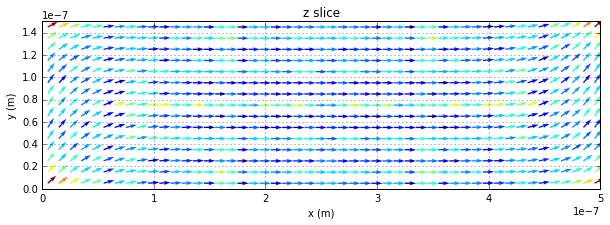

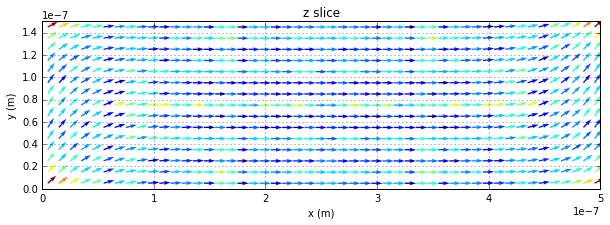

In [8]:
# Compute the average magnetisation.
print('The average magnetisation is {}.'.format(system.m.average()))

# Sample the magnetisation at the point.
c = (50e-9, 75e-9, 1e-9)
print('The magnetisation at point {} is {}.'.format(c, system.m(c)))

# Plot the slice.
%matplotlib inline
system.m.plot_slice('z', 1e-9)

## Second stage

In the second stage, the relaxed state from the first stage is used as an initial state. Now, the external magnetic field is applied $\mathbf{H}_{1} = (-24.6, 4.3, 0.0) \,\text{mT}$.

In [9]:
# Add Zeeman energy.
H = np.array([-24.6, 4.3, 0.0])*1e-3 / mu0  # external magnetic field in the first stage
system.hamiltonian += Zeeman(H)

In this stage, we use a smaller value of Gilbert damping in comparison to the first stage, where default value (alpha=1) was used.

Now, we can run the simulation for $1 \,\text{ns}$ and save the magnetisation field at 500 time steps.

In [10]:
t = 1e-9
n = 200

td = TimeDriver()
td.drive(system, t=t, n=n)

## Postprocessing

A detailed table of all computed parameters from the multiple stage simulation can be shown from the pandas dataframe.

In [11]:
system.dt.head(10)

,E,Ecount,max_dm/dt,dE/dt,deltaE,Eex,max_spin_angle,stage_max_spin_angle,run_max_spin_angle,Ed,FixedZeeman:zeeman:Energy,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,4.902994e-18,37.0,1229.528938,-4.765048e-10,-9.052731e-22,1.202130e-19,11.619924,15.652225,15.652225,6.841880e-19,4.098593e-18,6.0,6.0,0.0,0.953322,0.158548,-0.006882,2.034112e-12,5.000000e-12
1,4.900443e-18,50.0,1021.280239,-5.311251e-10,-6.688027e-22,1.317869e-19,12.746227,12.746227,15.652225,6.879672e-19,4.080689e-18,9.0,2.0,1.0,0.950550,0.165824,-0.013645,1.266532e-12,1.000000e-11
2,4.897535e-18,63.0,1354.102932,-6.760680e-10,-9.406876e-22,1.467631e-19,12.150032,12.746227,15.652225,7.001023e-19,4.050669e-18,12.0,2.0,2.0,0.945849,0.177713,-0.020202,1.465317e-12,1.500000e-11
3,4.893566e-18,76.0,1350.916565,-9.059699e-10,-1.284278e-21,1.583670e-19,12.407816,12.407816,15.652225,7.271502e-19,4.008049e-18,15.0,2.0,3.0,0.939079,0.194047,-0.026551,1.465317e-12,2.000000e-11
4,4.888511e-18,89.0,1560.377577,-1.139588e-09,-1.609089e-21,1.703324e-19,14.477749,14.477749,15.652225,7.661456e-19,3.952033e-18,18.0,2.0,4.0,0.930012,0.214548,-0.032650,1.465317e-12,2.500000e-11
5,4.882055e-18,102.0,1653.319480,-1.444166e-09,-2.054074e-21,1.788864e-19,12.841377,14.477749,15.652225,8.210017e-19,3.882167e-18,21.0,2.0,5.0,0.918479,0.238832,-0.038513,1.465317e-12,3.000000e-11
6,4.874149e-18,115.0,1342.095180,-1.731307e-09,-2.469510e-21,1.926577e-19,15.601139,15.601139,15.652225,8.836950e-19,3.797796e-18,24.0,2.0,6.0,0.904254,0.266459,-0.044098,1.465317e-12,3.500000e-11
7,4.864630e-18,128.0,1647.607487,-2.086485e-09,-2.980100e-21,2.054670e-19,13.444873,15.601139,15.652225,9.606801e-19,3.698483e-18,27.0,2.0,7.0,0.887163,0.296999,-0.049367,1.465317e-12,4.000000e-11
8,4.853352e-18,141.0,1552.712178,-2.428201e-09,-3.484309e-21,2.196728e-19,13.140240,13.444873,15.652225,1.050172e-18,3.583507e-18,30.0,2.0,8.0,0.866962,0.329978,-0.054305,1.465317e-12,4.500000e-11
9,4.840313e-18,154.0,1731.108823,-2.797483e-09,-4.018305e-21,2.310351e-19,14.331290,14.331290,15.652225,1.156830e-18,3.452448e-18,33.0,2.0,9.0,0.843471,0.364910,-0.058949,1.465317e-12,5.000000e-11


A single computed parameter (average my and simulation time in this case) can be extracted as an array using:

In [12]:
my_average = system.dt['my'].as_matrix()
t_array = system.dt['t'].as_matrix()

After we obtained the averae magnetisation, we can plot it and compare to the already reported results in Ref. 1.

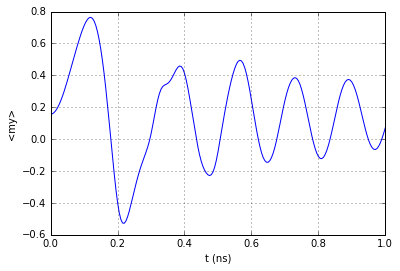

In [13]:
import matplotlib.pyplot as plt

# Plot the <my> time evolution.
plt.plot(t_array/1e-9, my_average)
plt.xlabel('t (ns)')
plt.ylabel('<my>')
plt.grid()

### References
[1] http://www.ctcms.nist.gov/~rdm/mumag.org.html